In [1]:
import os
os.chdir("..")

In [5]:
import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor

import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
SAMPLE_SIZE = 500
root_path = Path().resolve()

chall1 = root_path/"data/processed/chall1/train"
nevus_imgs = np.random.choice(list((chall1/'nevus').glob("*inpaint_0_5.png")), SAMPLE_SIZE)
others_imgs = np.random.choice(list((chall1/'others').glob("*inpaint_0_5.png")), SAMPLE_SIZE)
test_imgs = np.concatenate([nevus_imgs, others_imgs])

brisk = cv2.BRISK_create(thresh=30, octaves=0)


color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'lab':cv2.COLOR_RGB2LAB,  'YCrCb':cv2.COLOR_RGB2YCrCb}
mshift_params = {'sp': 10, 'sr': 15} # spatial and color range radius


dense_brisk_color = ColorDescriptor(brisk, color_spaces, meanshift=mshift_params,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25)

dense_brisk = DenseDescriptor(descriptor=brisk, min_keypoints=100, max_keypoints=500, kp_size=10)


In [7]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    img_cls = 1 if 'nevus' in str(image_path) else 0
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls)

descriptors = []
img_classes = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)

100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s]


In [8]:
descriptors_color = []
img_classes_color = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/vzalevskyi/anaconda3/envs/dev/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 1000/1000 [08:54<00:00,  1.87it/s] 


In [9]:
# # BRISK doesnt output a stable number of keypoints after .compute()
# _load_and_extract_des((test_imgs[10], dense_brisk))[0].shape

In [10]:
pd.to_pickle((descriptors_color, img_classes_color), 'descriptors_color.pkl')
pd.to_pickle((descriptors, img_classes), 'descriptors_brisk.pkl')
# descriptors, img_classes = pd.read_pickle('descriptors.pkl')

1000 100 64


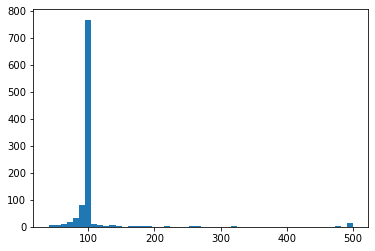

In [11]:
print(len(descriptors), len(descriptors_color[0]), len(descriptors[0][0]))
plt.hist([len(d) for d in descriptors], bins=50)
plt.show()

1000 100 96


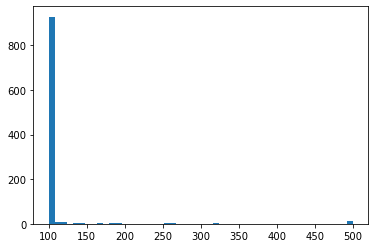

In [12]:
print(len(descriptors_color), len(descriptors_color[0]), len(descriptors_color[0][0]))
plt.hist([len(d) for d in descriptors_color], bins=50)
plt.show()

Brisk Dense

In [13]:
X_train, X_test, y_train, y_test = train_test_split(descriptors, img_classes, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       165
           1       0.73      0.61      0.67       165

    accuracy                           0.69       330
   macro avg       0.70      0.69      0.69       330
weighted avg       0.70      0.69      0.69       330

Accuracy: 0.693939393939394

Confusion Matrix: 
[[128  37]
 [ 64 101]]


Color descriptors

In [14]:
X_train, X_test, y_train, y_test = train_test_split(descriptors_color, img_classes_color, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       165
           1       0.76      0.73      0.75       165

    accuracy                           0.75       330
   macro avg       0.75      0.75      0.75       330
weighted avg       0.75      0.75      0.75       330

Accuracy: 0.7515151515151515

Confusion Matrix: 
[[127  38]
 [ 44 121]]


Pure color features

In [15]:
proc_data = Path().resolve() / 'data/processed'
test_path = proc_data / f'{"chall1"}/{"train"}/{"meanshift"}'
feat_type = "meanshift"
nevus_data = pd.read_feather(test_path.parent / f'nevus_color_features_{feat_type}.feather').set_index('name')
nevus_data['class'] = 0
others_data = pd.read_feather(test_path.parent/ f'others_color_features_{feat_type}.feather').set_index('name')
others_data['class'] = 1
data = pd.concat([nevus_data, others_data])

current_test_data = data.loc[[str(x.name).split('_')[0] for x in test_imgs]]
current_test_data

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,class
name,,,,,,,,,,,,,,,,,,,,,
nev07513,146.655762,19.251450,-0.403410,-1.022156,187.0,111.0,8.155974,76.0,59.152489,11.866448,...,214.0,44.141968,4.492908,-0.906165,-0.523932,49.477200,34.467464,8.159431,204.0,0
nev01588,80.992828,20.091002,0.227845,-0.201634,134.0,46.0,8.619627,89.0,60.288239,11.087918,...,549.0,9.868258,5.169036,0.688347,0.017078,25.660040,2.648839,8.514823,549.0,0
nev01624,156.885971,13.936283,-0.433676,1.244243,197.0,101.0,8.715460,86.0,94.683060,19.060095,...,390.0,35.283390,3.112739,-1.440673,2.346593,40.032455,19.007662,8.715392,380.0,0
nev06956,106.116730,18.237257,-0.670996,-0.344864,149.0,61.0,8.932500,87.0,55.636032,18.365770,...,567.0,28.533558,2.526369,-1.332269,1.970142,35.166824,12.823963,8.943962,557.0,0
nev04956,117.786598,18.222092,-0.119038,-0.457624,158.0,77.0,10.147625,82.0,85.886353,20.482538,...,879.0,20.071878,4.780309,-1.860013,5.808856,26.709082,-2.173363,-inf,879.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bkl00145,152.711884,18.509604,-0.907911,0.300632,213.0,93.0,10.875199,112.0,105.031624,16.125689,...,3383.0,26.372290,6.393518,-0.150835,-1.021469,43.486950,9.831939,10.852497,3383.0,1
mel01827,119.013527,26.793489,-0.515977,-0.806132,177.0,47.0,8.900931,124.0,55.907150,21.161577,...,3652.0,29.286945,9.075576,-0.385530,-0.218303,47.778427,-0.604876,-inf,3440.0,1
bcc00061,163.637131,6.384164,-0.976792,3.157699,192.0,125.0,11.004755,67.0,129.477478,15.334460,...,4028.0,16.572613,6.115778,-0.403848,0.029513,37.952984,-8.213239,-inf,4028.0,1


In [16]:

all_X = current_test_data.drop(columns=['class']).values
all_y = current_test_data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       150
           1       0.92      0.93      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300

Accuracy: 0.9266666666666666

Confusion Matrix: 
[[138  12]
 [ 10 140]]
